### IRF for different $(\delta, \lambda, \alpha)$ under the global demand channel

The impulse response function (IRF) for price is defined as

$$
\mathbb E \left(P_{t+k} \mid R_t^a = \tilde R_t^a, A_t = \tilde A_t, X_{t-1}, R_{t-1}^a \right)
    - \mathbb E \left(P_{t+k} \mid X_{t-1}, R_{t-1}^a \right),
\quad k = 0,1, \dots, K,
$$
where
$$
\tilde R_t^a = \mu_R (1-\rho_R) + \rho_R R_{t-1}^a + \Delta
\quad \text{and} \quad
\tilde A_t = \rho_A A_{t-1} - \gamma (R_t^a - \mu_R)
$$

and $\Delta$ represents the level of shock to $\varepsilon_t^R$ and the interest rate. We consider impulse responses in percentages when necessary. 
  
Since $\{(R_t^a,A_t)\}$ is a finite Markov chain, to properly represent the shock to the interest rate for a given $R_{t-1}^a$, we find the state point that is closest to $(\tilde R_t^a, \tilde A_t)$. As long as the discretizaion is sufficiently fine, the resulting error is minor. 

In [1]:
run pricing_demand

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["figure.autolayout"] = True

### Global parameters

In [3]:
# Gaussian quadrature sample points and weights
gq_points, gq_weights = gauss_quadra()

# State points and prob trans matrix 
Π, Ra_vals, EA_vals = build_dynamics(grid_sizes=[39,41], random_state=123)

# Size of MC samples & forwarding steps for IRF
size, periods = 100_000, 40
M = len(Ra_vals)

α = 0.2  # effect of economic activity on commodity demand

# Solve the competitive storage model
cp = CommodityPricing(δ=0.02,
                      λ=0.06,
                      κ=0.0,
                      σ_Y=0.05,
                      α=α,
                      Ra_vals=Ra_vals, EA_vals=EA_vals, Π=Π,
                      grid_size=100,
                      gq_points=gq_points,
                      gq_weights=gq_weights)
test_stability(cp, verbose=True)
# x_star, p_star = solve_model_time_iter(cp, T, print_skip=10, verbose=True)

# Number of MC and discarded samples to approx the stat dist of $(X_t,R_t)$
L, burn_in = 200_000, 50_000

# Simulate {Z_t} indices process
mc = MarkovChain(cp.Π)
Z_seq = mc.simulate(L+1, random_state=1234)

# Simulate {Y_t^S} process
Y_S_sim = truncnorm.rvs(a=-cp.trunc_Y,
                        b=cp.trunc_Y,
                        size=L+1,
                        loc=cp.μ_Y,
                        scale=cp.μ_Y*cp.σ_Y,
                        random_state=5678)

# Key parameters choices
λs = [0.03, 0.06, 0.09, 0.12, 0.15]
δs = [0.01, 0.02, 0.03, 0.04, 0.05]
αs = [0., 0.1, 0.2, 0.3, 0.4]


TRUNCATED_NORMAL_RULE
  Python version: 3.10.14

  For the (truncated) Gaussian probability density function
    pdf(x) = exp(-0.5*((x-MU)/SIGMA)^2) / SIGMA / sqrt ( 2 * pi )
  compute an N-point quadrature rule for approximating
    Integral ( A <= x <= B ) f(x) pdf(x) dx

  The value of OPTION determines the truncation interval [A,B]:
  0: (-oo,+oo)
  1: [A,+oo)
  2: (-oo,B]
  3: [A,B]

  The user specifies OPTION, N, MU, SIGMA, A, B and FILENAME.

  HEADER is used to generate 3 files:

    header_w.txt - the weight file
    header_x.txt - the abscissa file.
    header_r.txt - the region file, listing A and B.

  OPTION = 3
  N = 7
  MU = 0
  SIGMA = 1
  A = -5
  B = 5
  HEADER = "gauss_quad"

  Creating quadrature files.

  Common header is      "gauss_quad".

  Weight file will be   "gauss_quad_w.txt".
  Abscissa file will be "gauss_quad_x.txt".
  Region file will be   "gauss_quad_r.txt".

TRUNCATED_NORMAL_RULE:
  Normal end of execution.

Stability condition holds: G < exp(δ).

G

### IRF (multi-periods)

In [4]:
def irf_param_H(δs, λs, αs, Z0, Z_irf, X0_perc, shock, periods=40):
    """
    IRF for different (δs, λs, αs, Z0, Z_irf, X0_perc, shock, periods) values.
    Multiple (δs, λs, αs).
    """
    irf_P, irf_I, irf_PV = [np.empty((periods,len(δs),len(λs),len(αs))) for i in range(3)]
    moments = np.empty((5,len(δs),len(λs),len(αs)))
    for i, δ in enumerate(δs):
        for j, λ in enumerate(λs):
            for k, α in enumerate(αs):
                impul_P, impul_I, _, _, impul_PV, mom = irf_vs_params(δ, λ, α, L, burn_in, Z0, Z_irf, X0_perc,
                                                                      Ra_vals, EA_vals, Π, Z_seq, Y_S_sim, 
                                                                      gq_points, gq_weights, size=size, 
                                                                      periods=periods, n_expectations=1000)
                irf_P[:,i,j,k], irf_I[:,i,j,k], irf_PV[:,i,j,k] = impul_P, impul_I, impul_PV
                moments[:,i,j,k] = mom
    
    return irf_P, irf_I, irf_PV, moments

In [5]:
X0_perc, R0_perc, EA0_perc = 50, 50, 50
shock = 0.01
Z0, Z_irf = find_Zs(Ra_vals, R0_perc, Ra_vals, EA_vals, EA0_perc, EA_vals, shock)

#### Compute IRF vs $\delta$ (for fixed $\lambda$ and $\alpha$)

In [6]:
λ_set = [0.06]
α_set = [0.2]
irf_PH_δ, irf_IH_δ, irf_PVH_δ, moments_δ = irf_param_H(δs, λ_set, α_set, Z0, Z_irf, X0_perc, shock)
irf_PH_δ, irf_IH_δ, irf_PVH_δ, moments_δ = irf_PH_δ[:,:,0,0], irf_IH_δ[:,:,0,0], irf_PVH_δ[:,:,0,0], moments_δ[:,:,0,0]

#### Compute IRF vs $\lambda$ (for fixed $\delta$ and $\alpha$)

In [7]:
δ_set = [0.02]
α_set = [0.2]
irf_PH_λ, irf_IH_λ, irf_PVH_λ, moments_λ = irf_param_H(δ_set, λs, α_set, Z0, Z_irf, X0_perc, shock)
irf_PH_λ, irf_IH_λ, irf_PVH_λ, moments_λ = irf_PH_λ[:,0,:,0], irf_IH_λ[:,0,:,0], irf_PVH_λ[:,0,:,0], moments_λ[:,0,:,0]

#### Compute IRF vs $\alpha$ (for fixed $\delta$ and $\lambda$)

In [8]:
λ_set = [0.06]
δ_set = [0.02]
irf_PH_α, irf_IH_α, irf_PVH_α, moments_α = irf_param_H(δ_set, λ_set, αs, Z0, Z_irf, X0_perc, shock)
irf_PH_α, irf_IH_α, irf_PVH_α, moments_α = irf_PH_α[:,0,0,:], irf_IH_α[:,0,0,:], irf_PVH_α[:,0,0,:], moments_α[:,0,0,:]

#### Check conditional covariance

In [9]:
np.array([moments_δ[4,:], moments_λ[4,:], moments_α[4,:]])

array([[-1.24445331e-04, -1.20055538e-04, -1.15934551e-04,
        -1.12390602e-04, -1.09320828e-04],
       [-1.93960542e-04, -1.20055538e-04, -8.80530538e-05,
        -6.97689393e-05, -5.77760277e-05],
       [-2.67760366e-05, -7.37111825e-05, -1.20055538e-04,
        -1.64307344e-04, -2.05183654e-04]])

#### IRF plot

In [10]:
# dat = np.load('../output/simulation_results/irf_demand_param.dat.npz')
# irf_PH_δ = dat['irf_PH_δ'] 
# irf_IH_δ = dat['irf_IH_δ'] 
# irf_PVH_δ = dat['irf_PVH_δ'], 
# irf_PH_λ = dat['irf_PH_λ'] 
# irf_IH_λ = dat['irf_IH_λ'] 
# irf_PVH_λ = dat['irf_PVH_λ']
# irf_PH_α = dat['irf_PH_α'] 
# irf_IH_α = dat['irf_IH_α'] 
# irf_PVH_α = dat['irf_PVH_α']
# moments_δ = dat['moments_δ']
# moments_λ = dat['moments_λ']
# moments_α = dat['moments_α']
# λ_set = [0.06]
# α_set = [0.2]
# δ_set = [0.02]

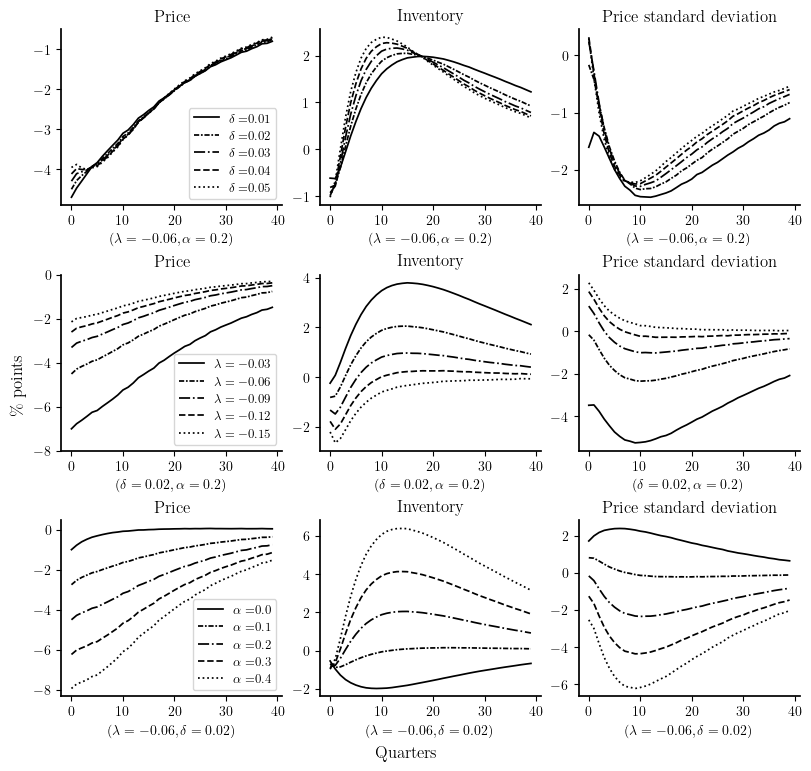

In [11]:
fig, axes = plt.subplots(3,3, figsize=(8,7.6), layout='constrained', 
                         gridspec_kw={'width_ratios': [5,5,5]})
fig.set_constrained_layout_pads(w_pad=3./72., h_pad=3./72.)
irf_set1 = [irf_PH_δ, irf_IH_δ, irf_PVH_δ]
irf_set2 = [irf_PH_λ, irf_IH_λ, irf_PVH_λ]
irf_set3 = [irf_PH_α, irf_IH_α, irf_PVH_α]
irf_sets = [irf_set1, irf_set2, irf_set3]
lss = ['-', (0,(3,1,1,1)), '-.', '--', ':']
titles = ['Price', 'Inventory', 'Price standard deviation']
lw = 1.25

for k in range(len(irf_sets)):
    for j in range(len(irf_set1)):
        ax = axes[k,j]
        ax.spines['left'].set_linewidth(1.25)
        ax.spines['bottom'].set_linewidth(1.25)
        ax.set_title(titles[j], fontweight='bold')
        ax.set_xticks([0,10,20,30,40])
        if k == 0:
            for i, δ in enumerate(δs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw, 
                        label=f'$\\delta=${δ}')
                ax.set_xlabel(f'($\lambda=-{λ_set[0]}, \\alpha={α_set[0]}$)')
                if j == 0:
                    ax.legend(fontsize=9)
        elif k == 1:
            for i, λ in enumerate(λs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw, 
                        label=f'$\lambda=-${λ:.2f}')
                ax.set_xlabel(f'($\delta={δ_set[0]}, \\alpha={α_set[0]}$)')
                if j == 0:
                    ax.set_ylim(-8,0)
                    ax.legend(fontsize=9)
        else:
            for i, α in enumerate(αs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw, 
                        label=f'$\\alpha=${α}')
                ax.set_xlabel(f'($\lambda=-{λ_set[0]}, \delta={δ_set[0]}$)')
                if j == 0:
                    ax.legend(fontsize=9)
fig.supxlabel('Quarters')
fig.supylabel('$\%$ points')
plt.savefig('../output/figures/irf_demand_param.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [12]:
# np.savez('../output/simulation_results/irf_demand_param.dat',
#          irf_PH_δ=irf_PH_δ, irf_IH_δ=irf_IH_δ, irf_PVH_δ=irf_PVH_δ, moments_δ=moments_δ,
#          irf_PH_λ=irf_PH_λ, irf_IH_λ=irf_IH_λ, irf_PVH_λ=irf_PVH_λ, moments_λ=moments_λ,
#          irf_PH_α=irf_PH_α, irf_IH_α=irf_IH_α, irf_PVH_α=irf_PVH_α, moments_α=moments_α)